In [56]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(rc={'figure.figsize':(7,5), 'font.size' : 8})
sns.set_style('white')
warnings.filterwarnings('ignore')
random_seed = 500

In [58]:
df = pd.read_csv('data.csv', delimiter=',')
df = df[df['Department'] == 'Research & Development']
df = df[df['JobRole'] == 'Research Scientist']
df['Gender'] = df['Gender'].apply(lambda g: 0.0 if g == 'Male' else 1.0)
df = df[['Age','YearsWithCurrManager', 'TotalWorkingYears', 'YearsSinceLastPromotion', 'MonthlyIncome']]
# , 'EnvironmentSatisfaction', 'Gender', 'NumCompaniesWorked', 
# , 'JobInvolvement', 'StockOptionLevel'
# , 'WorkLifeBalance'
df.head(10)

,Age,YearsWithCurrManager,TotalWorkingYears,YearsSinceLastPromotion,MonthlyIncome
1,49,7,10,1,5130
3,33,0,8,3,2909
12,31,3,5,4,2911
16,32,5,7,0,3298
19,38,2,6,1,3944
23,21,0,0,0,1232
24,34,3,8,1,2960
26,32,7,10,6,3919
34,24,0,6,2,2293
35,43,4,6,1,2645


In [59]:
df.describe()

,Age,YearsWithCurrManager,TotalWorkingYears,YearsSinceLastPromotion,MonthlyIncome
count,292.000000,292.000000,292.000000,292.000000,292.000000
mean,34.236301,3.208904,7.715753,1.506849,3239.972603
std,8.592472,2.930030,4.941377,2.245259,1198.116113
min,18.000000,0.000000,0.000000,0.000000,1009.000000
25%,28.000000,1.000000,5.000000,0.000000,2386.000000
50%,33.000000,2.000000,7.000000,1.000000,2887.500000
75%,39.000000,5.000000,10.000000,2.000000,3902.500000
max,59.000000,17.000000,25.000000,13.000000,9724.000000


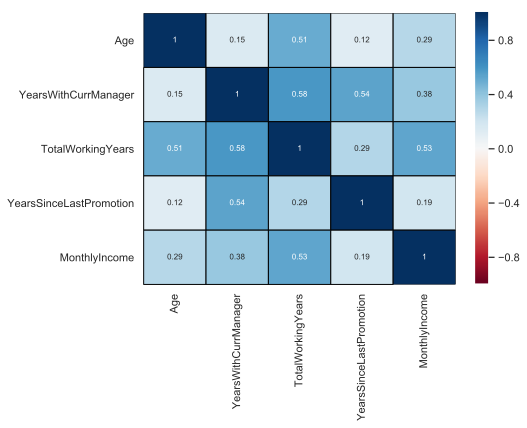

In [60]:
_ = sns.heatmap(df.corr(), cmap="RdBu", linecolor='black', linewidths = 1, vmin = -1, vmax = 1, annot = True)

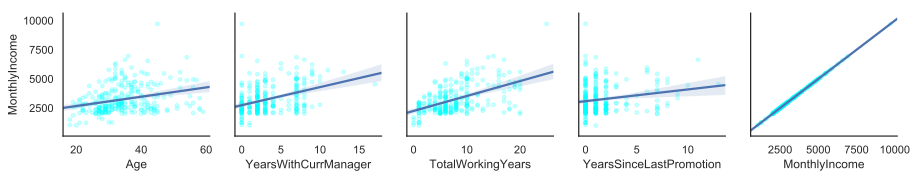

In [61]:
_ = sns.pairplot(data=df, x_vars=df.columns, y_vars=['MonthlyIncome'], kind="reg", plot_kws={'scatter_kws' : {'color' : 'cyan', 's' : 15, 'alpha' : 0.2}})

In [63]:
test_precent = 0.2
train_precent = 1.0 - test_precent
train_data = df.sample(frac=train_precent, random_state=random_seed)
test_data = df.drop(train_data.index)
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        average = x[feature_name].mean()
        std = x[feature_name].std()
        result[feature_name] = (x[feature_name] - average) / std
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)
normalized_train_data.head()

,Age,YearsWithCurrManager,TotalWorkingYears,YearsSinceLastPromotion,MonthlyIncome
382,-0.948903,0.297139,-0.166132,-0.666713,-0.136355
225,2.828122,-1.059555,-0.166132,-0.666713,-0.894972
565,-1.292269,-0.381208,-1.138003,-0.666713,0.194156
711,-0.605537,-1.059555,-0.943629,-0.666713,-0.708803
522,0.310105,-1.059555,-0.749255,-0.666713,1.157805


In [64]:
y_label='MonthlyIncome'
train_x = normalized_train_data.drop(y_label, axis = 1)
train_y = normalized_train_data[y_label]
test_x = normalized_test_data.drop(y_label, axis = 1)
test_y = normalized_test_data[y_label]


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

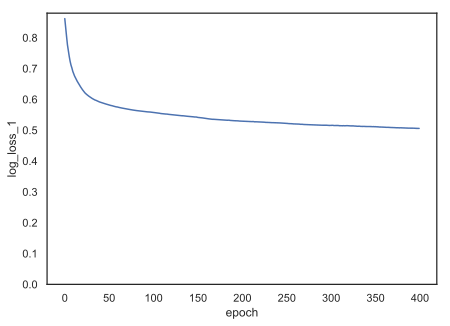

In [65]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 400


def show_history(history):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df['log_loss_1'] = np.log(history_df['loss'] + 1)
    sns.lineplot(data = history_df, y='log_loss_1', x='epoch')
    plt.gca().set_ylim(bottom=0)

def nn_mse(X,y, test_X, test_y):
    inputs_len = len(X.columns)
    input1 = Input(shape=(inputs_len,))
    hidden1 = Dense(inputs_len, activation='relu')(input1)
    hidden2 = Dense(inputs_len, activation='relu')(hidden1)
    out1 = Dense(1)(hidden2)
    model = Model(inputs=input1, outputs=out1)
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X, y, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])
    show_history(history)
    predicted = model.predict(X).flatten()
    expected = y
    train_NN_res = mean_squared_error(expected, predicted)
    predicted = model.predict(test_X).flatten()
    expected = test_y
    test_NN_res = mean_squared_error(expected, predicted)
    return train_NN_res, test_NN_res
train_NN_res, test_NN_res = nn_mse(train_x,train_y, test_x, test_y)

In [69]:
def fit_predict_mse_test(regressor, train_X, train_Y, test_X, test_Y):
    regressor.fit(train_X,train_Y)
    expected = regressor.predict(test_X)
    return mean_squared_error(expected, test_Y)
def fit_predict_mse_train(regressor, train_X, train_Y, test_X, test_Y):
    regressor.fit(train_X,train_Y)
    expected = regressor.predict(train_X)
    return mean_squared_error(expected, train_Y)

,Classifier,Data-Set,MSE
9,Linear,Train MSE,0.463795
10,KNN9,Train MSE,0.531301
11,SVM,Train MSE,0.564531
12,KNN7,Train MSE,0.572515
13,KNN5,Train MSE,0.617370
19,NN,Train MSE,0.657707
14,DTree4,Train MSE,0.668799
15,DTree3,Train MSE,0.675159
16,DTree2,Train MSE,0.705042
17,DTree5,Train MSE,0.708790


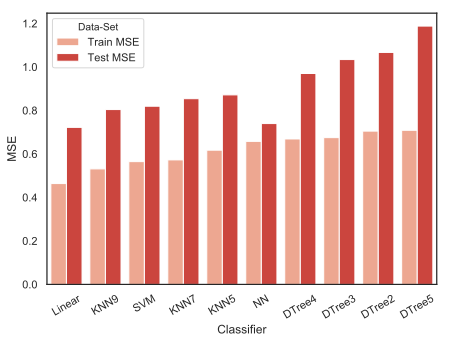

In [70]:
barplot = sns.barplot(data = melted_df, x = 'Classifier', y = 'MSE', hue = 'Data-Set', palette="Reds")
_ = barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30)